In [7]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

frames_folder = 'images/train'
empty_parking_folder = 'markup'
output = 'output'

In [8]:
def apply_best_blur(image, method="gaussian", kernel_size=3, sigma=0, diameter=9, sigma_color=200, sigma_space=200):
    if method == "gaussian":
        blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    elif method == "median":
        blurred_image = cv2.medianBlur(image, kernel_size)
    elif method == "bilateral":
        blurred_image = cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)
    else:
        raise ValueError("incorrect method")
    
    return blurred_image

In [9]:
def upscale_image(image, scale_factor=2):
    height, width = image.shape[:2]
    new_size = (int(width * scale_factor), int(height * scale_factor))
    upscaled_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return upscaled_image

In [10]:
def show_in_row(list_of_images, titles = None, disable_ticks = False):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])

        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

In [11]:
def main():
    template_files = sorted([f for f in os.listdir(empty_parking_folder) if f.endswith('.jpg') or f.endswith('.png')])
    templates = []
    for template_file in template_files:
        template_path = os.path.join(empty_parking_folder, template_file)
        template_image = cv2.imread(template_path)

        template_image = upscale_image(template_image, 4)
            
        template_image = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)
        template_image = apply_best_blur(template_image)

        if template_image is None:
            print(f"Error loading template {template_path}")
            continue
        
        templates.append({
            'image': template_image,
            'name': template_file
        })
    
    # Get list of frame files
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg') or f.endswith('.png')])
    
    for frame_file in frame_files:
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = apply_best_blur(frame)
        frame = upscale_image(frame, 4)
        
        if frame is None:
            print(f"Error loading frame {frame_path}")
            continue
        
        for _, template in enumerate(templates):
            res = cv2.matchTemplate(frame, template['image'], cv2.TM_CCOEFF_NORMED)
            frame_copy = frame
            w, h = template['image'].shape[::-1]

            # Define a threshold for detection
            threshold = 0.85
            loc = np.where(res >= threshold)

            for pt in zip(*loc[::-1]):
                cv2.rectangle(frame_copy, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

            show_in_row([frame_copy])
        
        # Display the frame
        show_in_row([frame])
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output + '/' + frame_file, frame)
    
    cv2.destroyAllWindows()

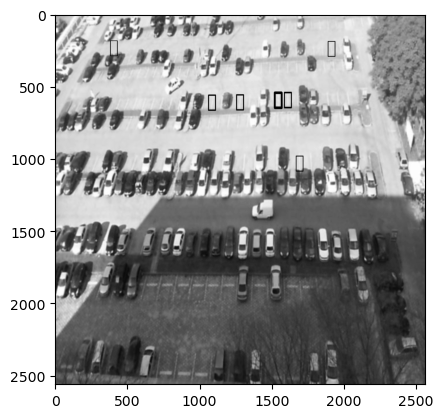

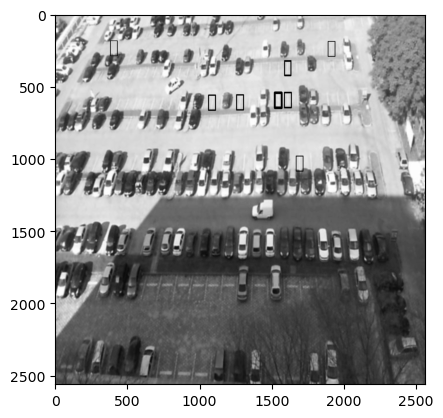

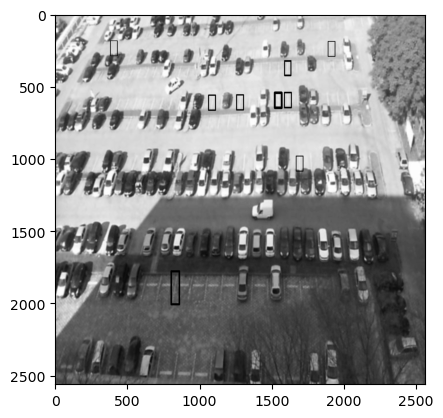

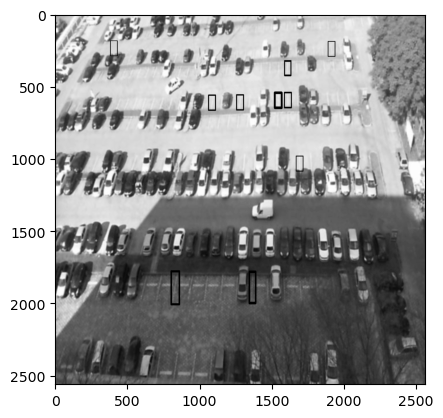

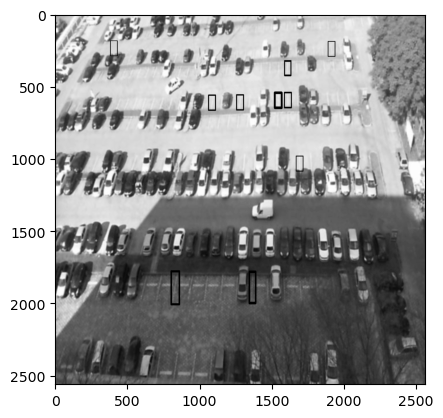

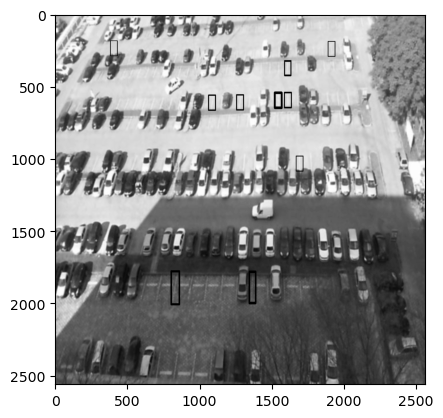

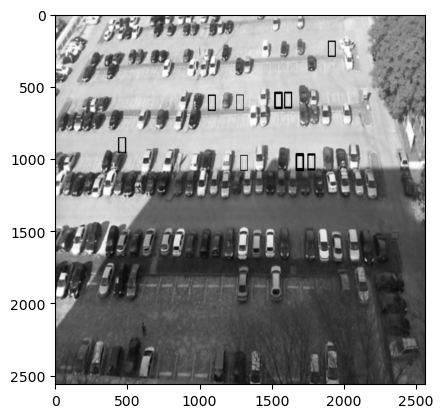

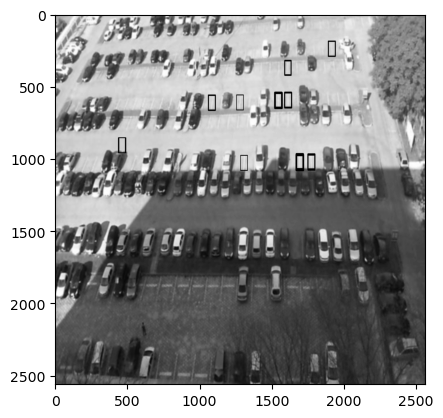

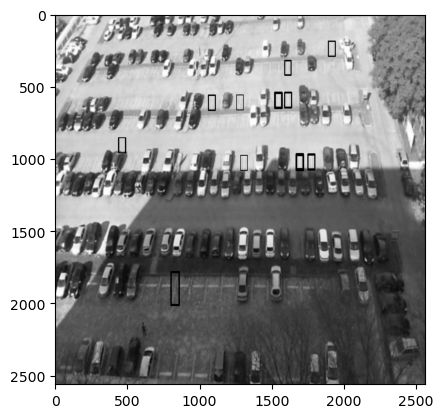

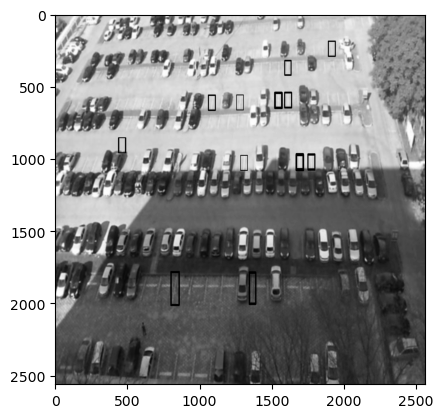

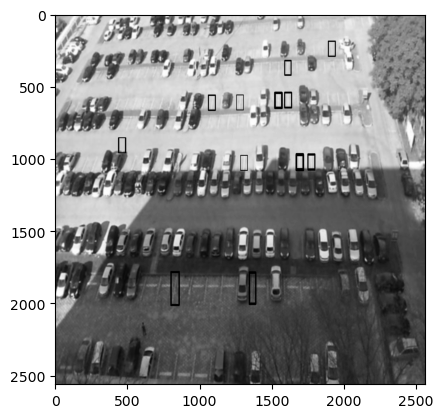

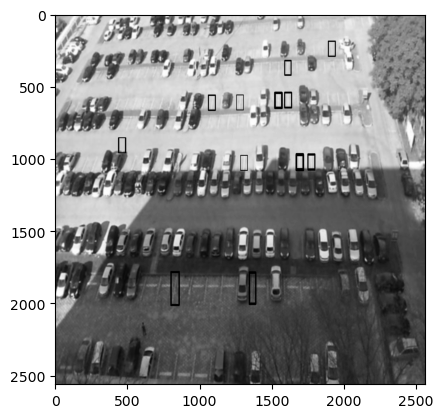

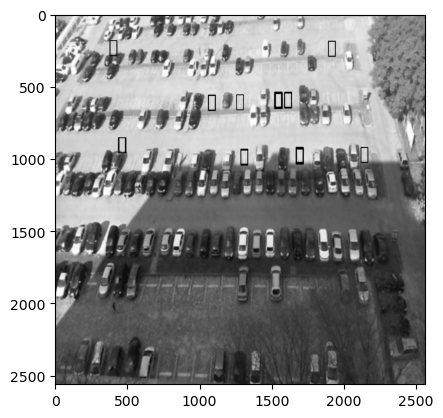

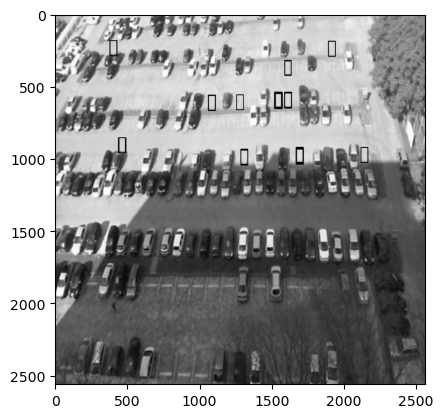

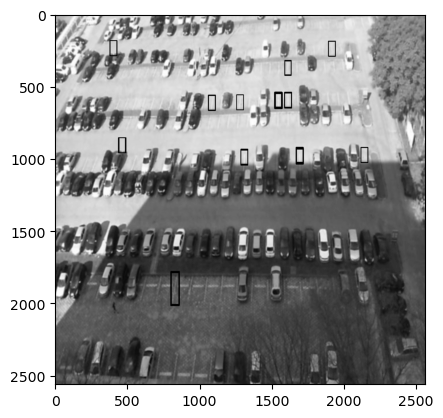

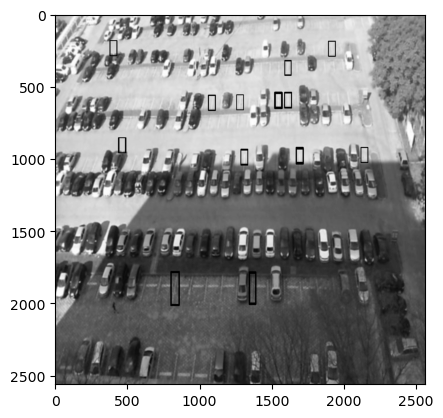

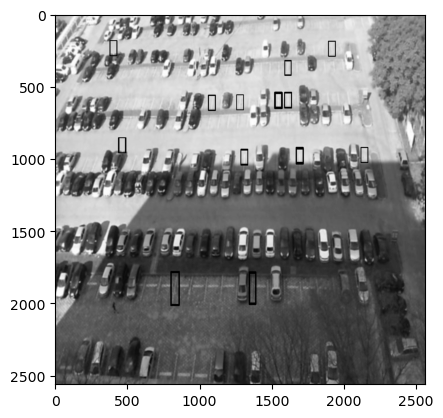

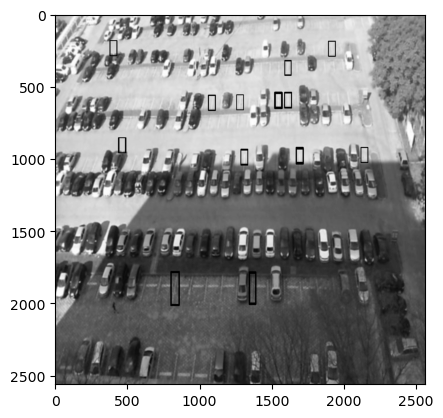

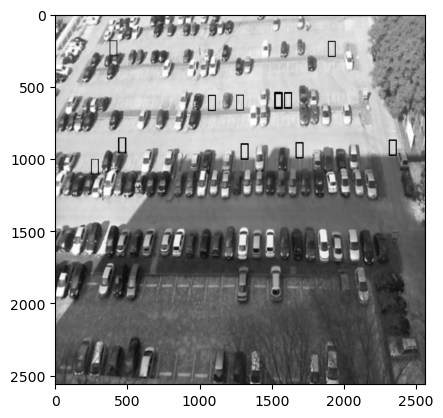

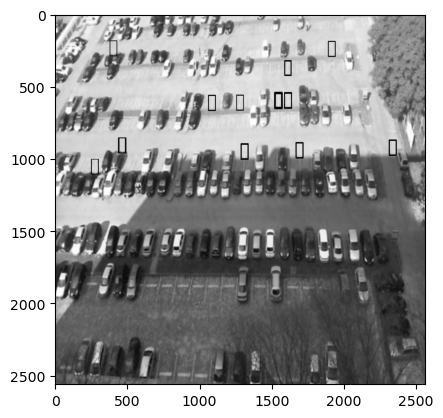

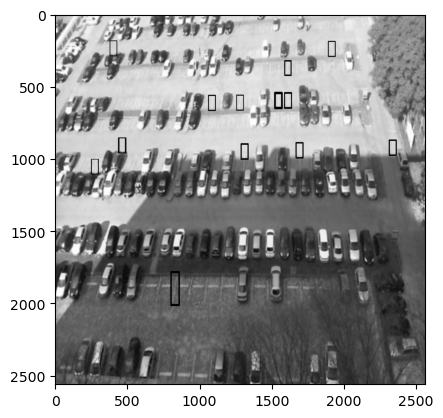

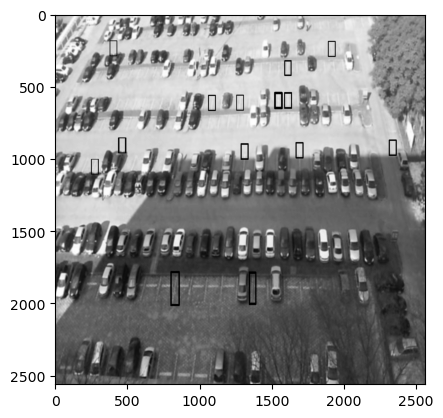

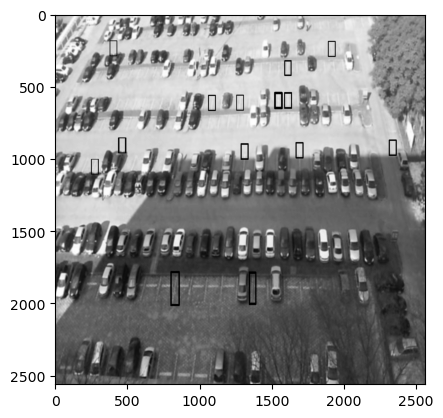

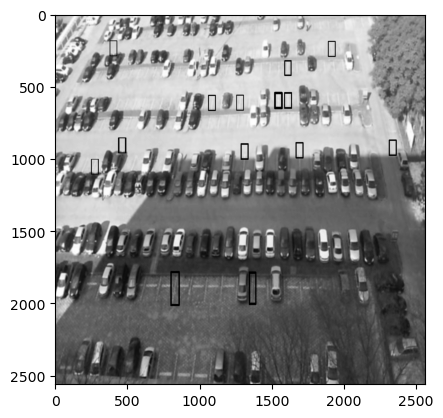

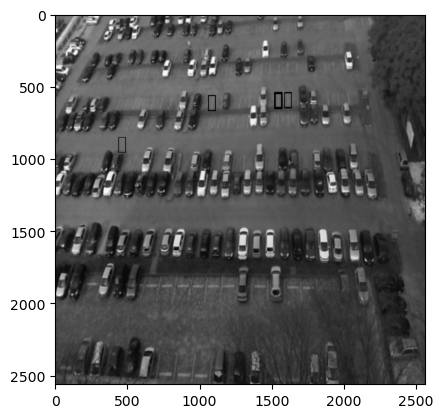

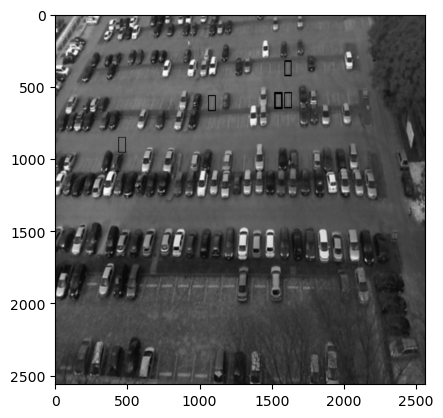

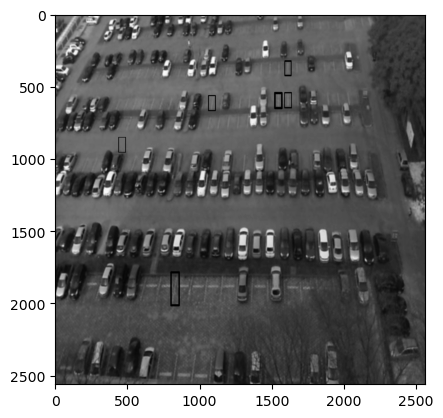

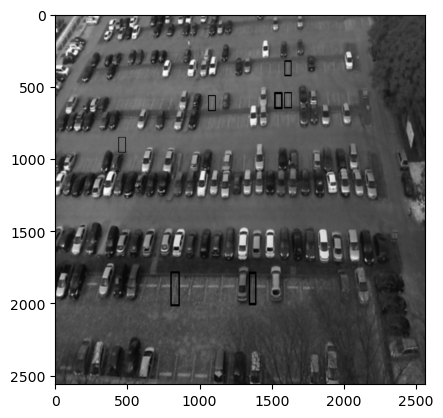

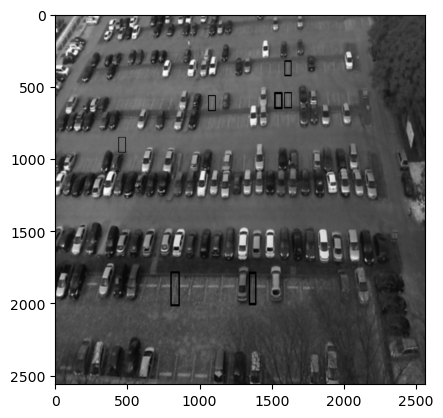

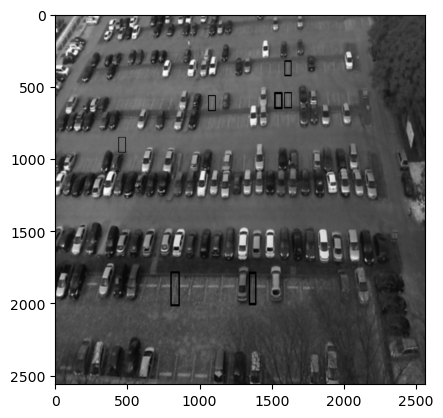

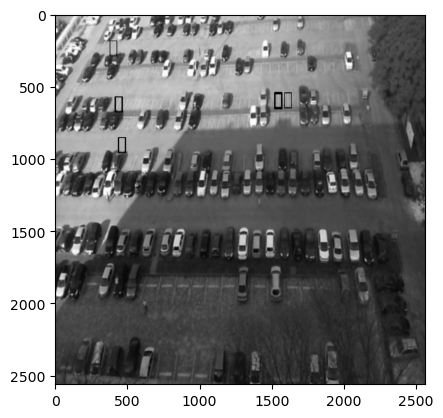

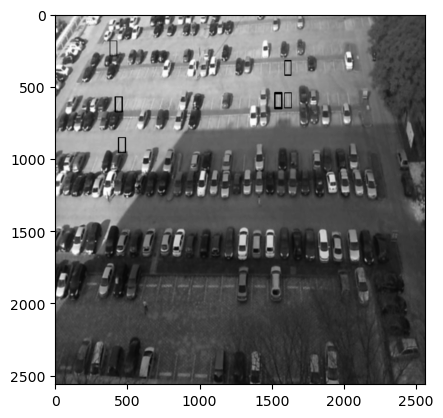

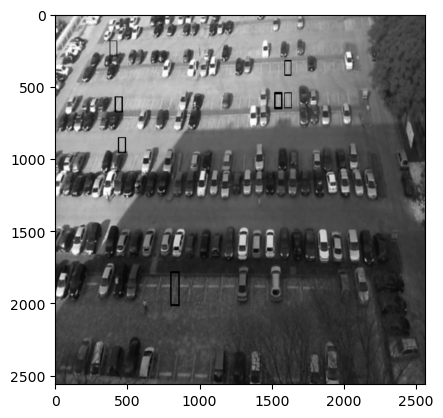

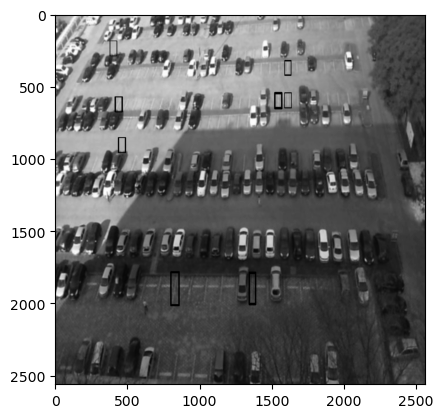

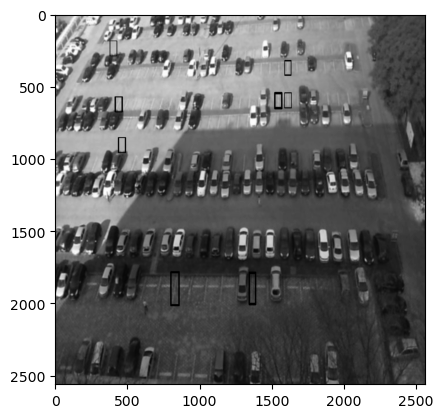

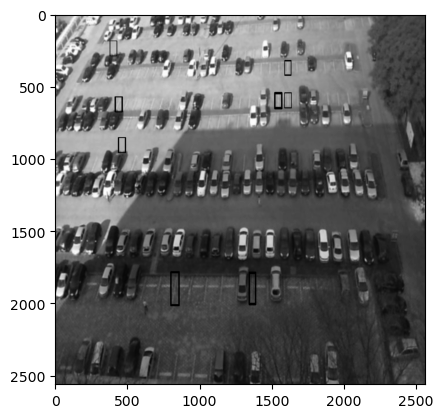

KeyboardInterrupt: 

In [12]:
if __name__ == "__main__":
    main()